In [1]:
%load_ext autoreload
%autoreload 2

from text3d2video.pipelines.pipeline_utils import load_pipeline
import torch
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.controlnet_pipeline import BaseControlNetPipeline

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
device = 'cuda'
pipe = load_pipeline(BaseControlNetPipeline, sd_repo, controlnet_repo)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
from text3d2video.util import read_obj_uvs
from text3d2video.utilities.camera_placement import turntable_extrinsics
from text3d2video.utilities.mesh_processing import normalize_meshes
from text3d2video.rendering import render_depth_map
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import FoVPerspectiveCameras


device = "cuda"
mesh_path = "data/meshes/mixamo-human.obj"

# read mesh
verts_uvs, faces_uvs = read_obj_uvs(mesh_path)
anim_meshes = load_objs_as_meshes([mesh_path], device=device)
anim_meshes = normalize_meshes(anim_meshes)

R, T = turntable_extrinsics(dists=1.5, angles=0, elevs=0)
view_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=40)
view_meshes = anim_meshes.extend(len(view_cams))

t_depth = render_depth_map(view_meshes, view_cams)[0]

In [42]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact
from pytorch3d.renderer import (
    join_cameras_as_batch,
)
from pytorch3d.structures import join_meshes_as_batch

rumba = AnimationArtifact.from_wandb_artifact_tag("rumba:latest")

frame_indices = rumba.frame_indices(5)
anim_cams, anim_meshes = rumba.load_frames(frame_indices)
anim_verts_uvs, anim_faces_uvs = rumba.uv_data()

all_meshes = join_meshes_as_batch([view_meshes, anim_meshes])
all_cams = join_cameras_as_batch([view_cams, anim_cams])

depths = render_depth_map(all_meshes, all_cams)

: 

100%|██████████| 30/30 [00:18<00:00,  1.61it/s]


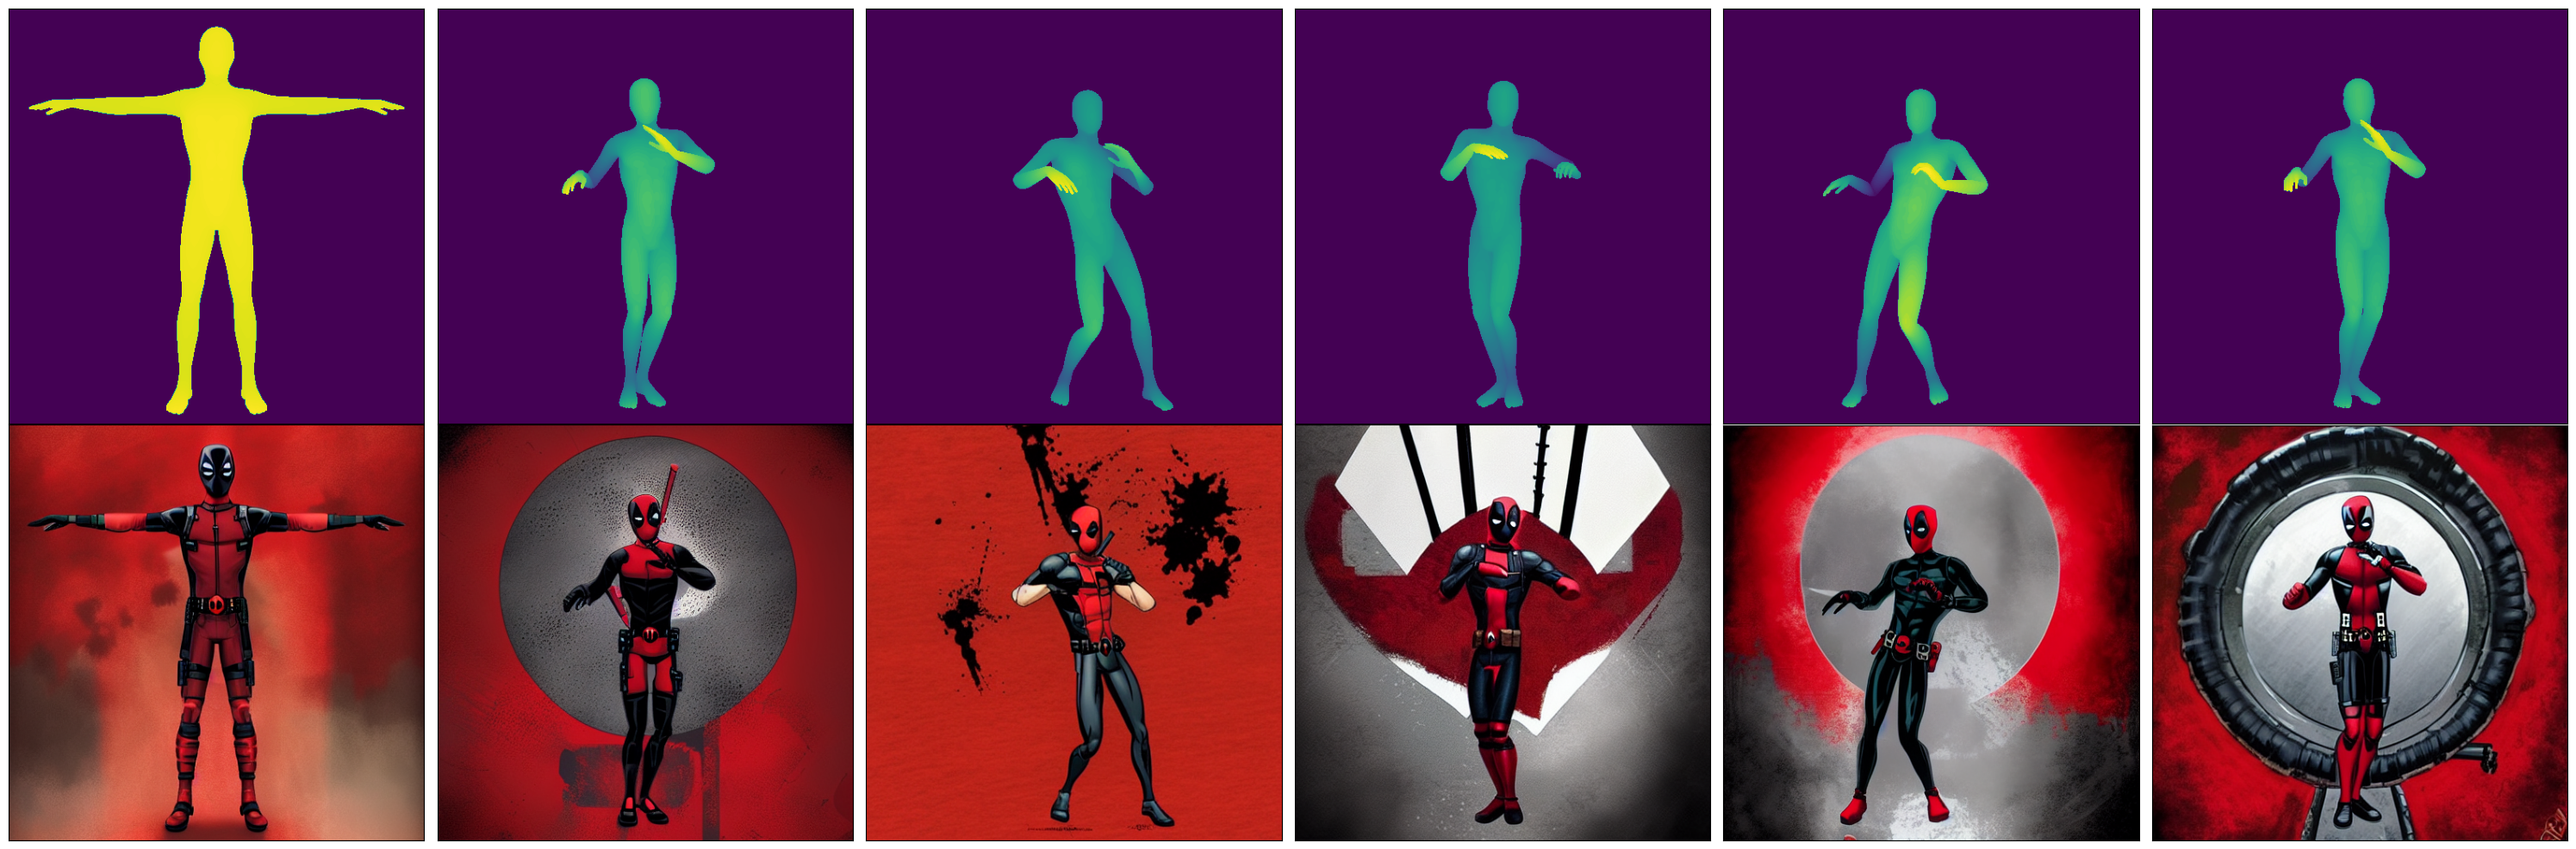

In [31]:
from pathlib import Path
from text3d2video.utilities.ipython_utils import display_ims_grid
from text3d2video.utilities.logging import GrLogger

prompt = "Deadpool"
seed = 1

gen = torch.Generator(device=device)
gen.manual_seed(seed)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=10)
logger.delete_data()
logger.open_write()
logger.enabled = True

images = pipe(
    [prompt] * len(depths),
    depths,
    generator=gen,
    num_inference_steps=30,
    controlnet_conditioning_scale=1,
    guidance_scale=7.5,
    logger=logger,
)

display_ims_grid([depths,images], scale=5)

In [32]:
import math

from einops import rearrange

keys_vals = logger.field_keys_and_vals("qry")
chunks = keys_vals["chunk"]
ts = sorted(keys_vals["t"], reverse=True)
layers = keys_vals["layer"]
frames = keys_vals["frame_i"]

In [33]:
from text3d2video.sd_feature_extraction import AttnLayerId, BlockType

layers_parsed = [AttnLayerId.parse(layer) for layer in layers]
layers_parsed = sorted(layers_parsed, key=lambda x: x.unet_absolute_index())

dec_layers = [layer for layer in layers_parsed if layer.block_type == BlockType.UP]
dec_layer_paths = [layer.module_path() for layer in dec_layers]

In [34]:
chunk = chunks[1]
t = ts[3]
layer_i = 1
layer = dec_layer_paths[layer_i]
frame = frames[0]

print("t", t)
print("layer", dec_layers[layer_i].unet_absolute_index())

qrys = [
    logger.read("qry", chunk=chunk, t=t, layer=layer, frame_i=frame, return_pt=True)
    for frame in frames
]
qrys = torch.stack(qrys)

h = int(math.sqrt(qrys.shape[1]))

qrys_square = rearrange(qrys, "b (h w) c -> b c h w", h=h)
qrys_square.shape

t 666
layer 8


torch.Size([6, 1280, 16, 16])

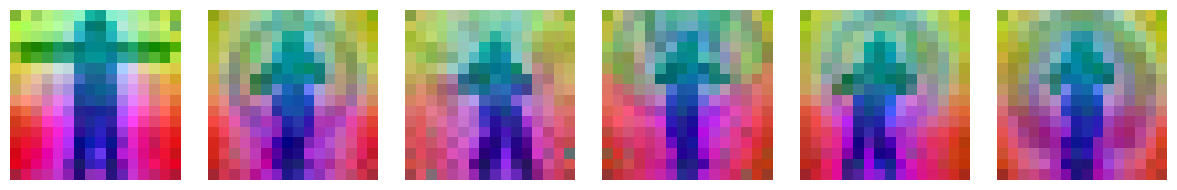

In [35]:
from text3d2video.feature_visualization import RgbPcaUtil

pca_frame = 0
pca_features = rearrange(qrys_square[0], "c h w -> (h w) c")
pca = RgbPcaUtil.init_from_features(pca_features)

qrys_pca = [pca.feature_map_to_rgb_pil(frame) for frame in qrys_square]
display_ims(qrys_pca)

In [ ]:
from text3d2video.backprojection import project_visible_texels_to_camera


mesh = all_meshes[0]
cam = all_cams[0]

project_visible_texels_to_camera(mesh, cam, anim_verts_uvs, anim_faces_uvs)



TypeError: project_visible_texels_to_camera() missing 3 required positional arguments: 'verts_uvs', 'faces_uvs', and 'texture_res'